# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [121]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [167]:
sigma = 0.1
n_reps = 5
true_bohr = np.linspace(-8, 8, 100)
dataset_fc = []
for i, b in enumerate(true_bohr):
    mu = (1 + np.exp(-b))**-1
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

In [168]:
# Load the stan model
model = mut.bayes.StanModel('../stan/empirical_F.stan')
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, control=dict(adapt_delta=0.95))
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'empirical_bohr',
                                                            'delta_bohr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

Found precompiled model. Loading...
finished!


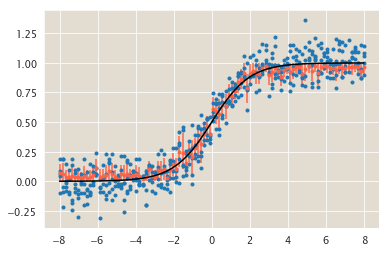

In [169]:
fc_mu = stats[stats['parameter']=='fc_mu']
plt.plot(dataset['true_bohr'], dataset['fold_change'], '.')
plt.plot(fc_mu['true_bohr'], fc_mu['mean'], '.', color='tomato')
plt.vlines(fc_mu['true_bohr'], fc_mu['hpd_min'], fc_mu['hpd_max'], color='tomato')
        
plt.plot(true_bohr, (1 + np.exp(-true_bohr))**-1, 'k-')

Even with this fake data set, wherer the features of teh generating distribution are well controlled, I see that I have upper and lower limits to the values of the fold-change that can be inferred. To figure out what this limit is, we can run this inference over and over again on data sets where the sigma is changing. For this, I will choose one value for the bohr parameter that is close to saturating fold-change (say $8 k_BT$). 

## Mapping inferential sensitifvity to the generating distribution

In [184]:
sigma_range = np.logspace(-4, 0, 1000)
seed_bohr = 6 #in kBT
n_reps = 5 
fc_mu = (1 + np.exp(-seed_bohr))**-1 # The true fold-change distribution
sigma_df = []
sigma_stats = []
for i, s in enumerate(tqdm.tqdm(sigma_range)):
    dataset = np.random.normal(fc_mu, s, n_reps)
    data_dict = {'N':n_reps, 'ref_bohr':seed_bohr, 'foldchange':dataset}
    fit, samples = model.sample(data_dict, control=dict(adapt_delta=0.99))
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma', 
                                                            'delta_bohr',
                                                           'empirical_bohr'],
                                        logprob_name='lp__')
    stats['true_sigma'] = s
    stats['true_fc'] = fc_mu
    stats['generated_fc_mu'] = np.mean(dataset)
    sigma_stats.append(stats)
sigma_stats = pd.concat(sigma_stats)
    


100%|██████████| 1000/1000 [06:13<00:00,  2.66it/s]


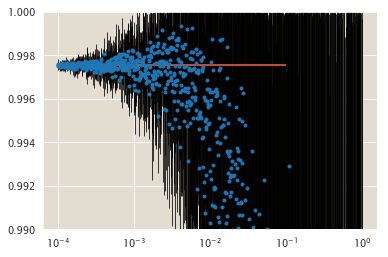

In [207]:
_fc_mu = sigma_stats[sigma_stats['parameter']=='fc_mu']
plt.semilogx(_fc_mu['true_sigma'], _fc_mu['median'], '.')
plt.vlines(_fc_mu['true_sigma'], _fc_mu['hpd_min'], _fc_mu['hpd_max'], lw=0.75)
plt.ylim([0.99, 1])
plt.hlines(fc_mu,1E-4, 1E-1, color='tomato')

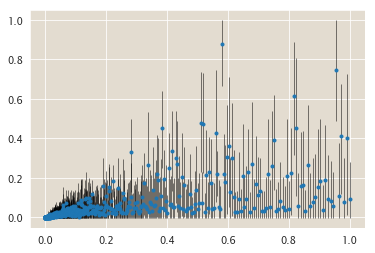

In [206]:
plt.plot(_fc_mu['true_sigma'], fc_mu - _fc_mu['median'], '.')
plt.vlines(_fc_mu['true_sigma'], fc_mu - _fc_mu['hpd_min'],fc_mu -  _fc_mu['hpd_max'], lw=0.5)
# plt.yscale('log')
# plt.xscale('log')


In [180]:
delta_fc = fc_mu - _fc_mu['median']
min_fx 

NameError: name 'min_fx' is not defined

In [102]:
-np.log(1 - (1 / ((fc_mu['median'].values/fc_sigma['median'].values) + 1)) *\
                           (1 / (1 - fc_mu['median'].values)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


array([1.35004919, 2.14856667, 1.295113  , 1.17970076, 1.71789235,
       1.32310296, 1.45578617, 1.91945833, 1.92148902, 2.04737317,
       1.64419015, 1.5493636 , 1.7907377 , 1.48957387, 2.00798576,
       1.61539145, 1.58935932, 1.36329012, 1.19745998, 1.66922904,
       0.98779022, 1.79161885, 1.9987495 , 1.65400528, 1.91611757,
       1.7468098 , 1.17669026, 0.85661647, 1.41675805, 1.12937119,
       1.63976784, 1.8770964 , 1.31390449, 1.61372095, 1.21733185,
       0.098944  , 0.78813842, 0.96767947, 0.85778071, 0.69659266,
       0.44079874, 0.57703277, 0.64916532, 0.57647759, 0.58132425,
       0.53328553, 0.65705789, 0.4701353 , 0.3741439 , 0.37545197,
       0.22936774, 0.5790601 , 0.38261964, 0.4795428 , 0.91994695,
       0.95457037, 0.81339676, 0.85812571, 0.83652727,        nan,
       1.09744189, 0.84436242,        nan,        nan, 1.8847802 ,
              nan,        nan,        nan,        nan, 2.11200765,
              nan,        nan,        nan,        nan,        

Text(0, 0.5, 'fold-change')

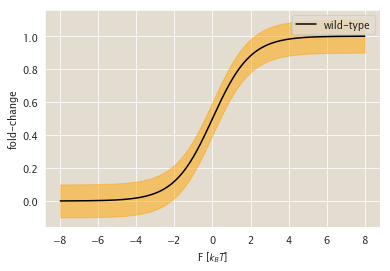

In [12]:
bohr_param_wt = np.linspace(-8, 8, 1000)
bohr_param_mut = bohr_param_wt - 2
delta = 0.1
fc_wt = (1 + np.exp(-bohr_param_wt))**-1
fc_ref_min = (1 + np.exp(-bohr_param_wt))**-1 - delta
fc_ref_max = (1 + np.exp(-bohr_param_wt))**-1 + delta
fc_mut_min = (1 + np.exp(-bohr_param_mut))**-1 - delta
fc_mut_max = (1 + np.exp(-bohr_param_mut))**-1 + delta

plt.plot(bohr_param_wt, fc_wt, 'k-', label='wild-type') 
plt.fill_between(bohr_param_wt, fc_ref_min, fc_ref_max, color='orange', alpha=0.5)                
plt.legend()
plt.xlabel('F [$k_BT$]')
plt.ylabel('fold-change')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


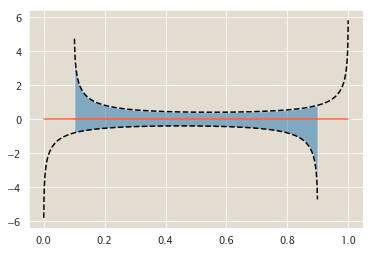

In [85]:
err_df_min = np.log(1 - (1 / ((fc_wt / delta) + 1)) * (1 / (1 - fc_wt)))
err_df_max = np.log(1 + (1 / ((fc_wt / delta) - 1)) * (1 / (1 - fc_wt)))
df_min = bohr_param_wt + np.log((1/fc_ref_min) - 1)
df_max = bohr_param_wt + np.log((1/fc_ref_max) - 1)
plt.fill_between(fc_wt, df_min, df_max, alpha=0.5)
plt.plot(fc_wt, df_min - err_df_max, '-', color='tomato')
plt.plot(fc_wt, df_max - err_df_min, '-', color='tomato')
plt.plot(fc_wt, df_min, '--', color='k')
plt.plot(fc_wt, df_max, '--', color='k')
# plt.plot(fc_ref_min, df - obs_ddf, '--', color='k')


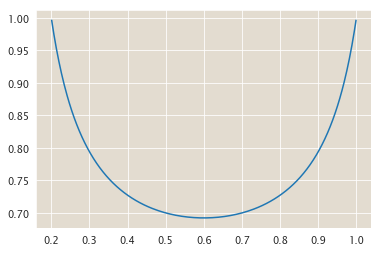

In [100]:
plt.plot(fc_ref_max, (1 / (1 + np.exp(err_df_min - err_df_max))))
# plt.plot(fc_ref_min, 1 / (1 + np.exp(err_df_max)))